# IVUS Challenge

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import cv2
import os
import keras

seed = 123
version = 1

2022-01-17 20:35:18.334627: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Prepare the data

### Read the images
The images are stored in the <i>Training_Set</i> folder. We will load the images from <i>Data_set_A</i>:

An empirical number of five temporally adjacent frames around the frame $F$ (two before and two after) have been included. It has been considered when more than two frames forward (and backward) in time are considered, consecutive IVUS frames might not be aligned. 

-  A training set: A subset (one fourth) of images from each dataset containing both images and manual annotations. The training set is meant for training and tuning of the algorithms prior to the evaluation. This dataset is distributed upon request for algorithm evaluation.
- A test set: The remaining frames compose the set of images that are used for performance evaluation. The annotations are not available before the algorithm evaluation in order to assure the complete blindness and equity of the algorithm assessment.

Annotations on the image datasets have been provided by four clinical experts, daily working with the specific IVUS echograph brand, and belonging to distinct medical centers. The annotation consists in the delineation of both inner wall (lumen contours) and outer wall (media/adventitia contours) on the IVUS images in the short-axis view. In all the cases, the experts were blinded to the other physicians’ annotations, and two of them repeated the manual annotations after about one week from the first labeling.


In [2]:
# Helper functions
def read_labels(directory, verbose=1):
    """
    Reads the labels from a given directory
    
    returns:
        A dictionary containing:
            'lum': array of labels of 2D coordinates
            'med': array of labels of 2D coordinates
    """
    labels_lum = []
    labels_med = []

    for file_name in sorted(os.listdir(directory)):
        points = []
        with open(os.path.join(directory, file_name)) as f:
            for line in f:
                c0, c1 = line.split(',')
                points.append((float(c0), float(c1)))

        if file_name.startswith("lum"):
            labels_lum.append(points)
        elif file_name.startswith("med"):
            labels_med.append(points)
    
    # We will have imbalances since the number of coordinates is not fixed
    # To use numpy array, we will extend every list of labels repeating the last element
    labels_lum = np.array(labels_lum, dtype=object)
    if type(labels_lum[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_lum[i]) for i in range(len(labels_lum))])
        for i in range(len(labels_lum)):
            labels_lum[i] = np.concatenate(
                (labels_lum[i], np.repeat([labels_lum[i][-1]],m-len(labels_lum[i]), axis=0))
            )
    
    labels_med = np.array(labels_med, dtype=object)
    if type(labels_med[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_med[i]) for i in range(len(labels_med))])
        for i in range(len(labels_med)):
            labels_med[i] = np.concatenate(
                (labels_med[i], np.repeat([labels_med[i][-1]],m-len(labels_med[i]), axis=0))
            )

    # We have np.arrays inside np.arrays, we have to undo this
    labels = {
        'lum': np.array([l.tolist() for l in labels_lum]),
        'med': np.array([l.tolist() for l in labels_med])
    }

    if verbose:
        print(f"Annotation for the inner wall (lumen contours): {labels['lum'].shape}")
        print(f"Annotation for the outer wall (media/adventitia contours): {labels['med'].shape}")
        
    return labels

def read_training_dataset(letter="A", verbose=1):
    """
    Reads the training dataset A or B
    
    returns:
        Two tuples (x_train, y_train_label), (x_test, y_test_label):
            x_train: dataset of images for training
            y_train_label: a dictionary containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
            x_test: dataset of images for testing
            y_test_label: a list of 3 dictionaries containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
    """
    path = os.path.join(os.path.dirname(os.getcwd()), "Training_Set", "Data_set_"+letter, "DCM")

    dataset = []
    subset = []

    count = 0
    for file_name in sorted(os.listdir(path)):
        count += 1
        subset.append(cv2.imread(os.path.join(path, file_name), cv2.IMREAD_GRAYSCALE))

        if count >= 5:
            dataset.append(subset)
            subset = []
            count = 0

    dataset = np.array(dataset)
    
    if verbose:
        print(f"Dataset {letter} has shape: {dataset.shape}")
    
    # Read the labels
    y_train_labels = []
    y_train_directory = os.path.join(os.path.dirname(os.getcwd()), "Training_Set", "Data_set_"+letter, "LABELS")
    for dir_name in ['LABELS_obs1']:
        directory = os.path.join(y_train_directory, dir_name)
        y_train_labels.append(read_labels(directory, verbose))
    
    num_training_labels = y_train_labels[0]['lum'].shape[0]
    x_train = dataset[:num_training_labels, :, :, :]
    
    x_test = dataset[num_training_labels:, :, :, :]
    
    # Read test labels
    y_test_labels = []
    y_test_directory = os.path.join(os.path.dirname(os.getcwd()), "Test_Set", "Data_set_"+letter)
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_test_directory, dir_name)
        y_test_labels.append(read_labels(directory, verbose))
    
    return (x_train, y_train_labels), (x_test, y_test_labels)

In [3]:
(x_train, y_train_labels), (x_test, y_test_labels) = read_training_dataset("A")

Dataset A has shape: (77, 5, 512, 512)
Annotation for the inner wall (lumen contours): (19, 360, 2)
Annotation for the outer wall (media/adventitia contours): (19, 360, 2)
Annotation for the inner wall (lumen contours): (58, 360, 2)
Annotation for the outer wall (media/adventitia contours): (58, 360, 2)
Annotation for the inner wall (lumen contours): (58, 611, 2)
Annotation for the outer wall (media/adventitia contours): (58, 521, 2)
Annotation for the inner wall (lumen contours): (58, 631, 2)
Annotation for the outer wall (media/adventitia contours): (58, 581, 2)


#### Downsample images for better training
Now we will downsample our training and test dataset in order to be more memory-efficient when training. We must note that when we downsample by a half our images (from 384x384 to 192x192 in dataset B), then we need to divide by 2 our contour coordinates as well.

In [4]:
from skimage.measure import block_reduce
def downsample_image(image):
    """Downsample image by half by applying mean pooling"""
    return block_reduce(image, block_size=(2,2), func=np.mean)

In [5]:
x_train_ds = []
for batch in x_train:
    x_train_ds.append([downsample_image(image) for image in batch])

x_train_ds = np.array(x_train_ds)
y_train_label_ds = []
for label in y_train_labels:
    y_train_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

x_test_ds = []
for batch in x_test:
    x_test_ds.append([downsample_image(image) for image in batch])

x_test_ds = np.array(x_test_ds)
y_test_label_ds = []
for label in y_test_labels:
    y_test_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

print(f"Training set now has shape {x_train_ds.shape}")
print(f"Test set now has shape {x_test_ds.shape}")

Training set now has shape (19, 5, 256, 256)
Test set now has shape (58, 5, 256, 256)


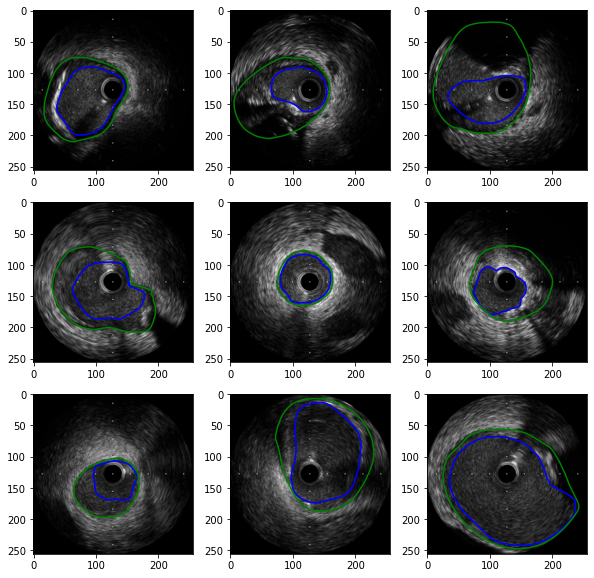

In [6]:
# Display some images
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-')
    plt.imshow(x_train_ds[i][2], cmap='gray')

### Create a set of mask images
We will use the labels we have to mask the interior of the paths they draw. Since we have three different classes: background, media and lumen; we will create a multiclass segmentation.

In [7]:
num_classes = 3
CLASSES = ['background', 'media', 'lumen']

In [8]:
def create_masks(x, y):
    """
    Create masks from a dataset and its labels
    
    parameters:
        x: dataset of images
        y: array of labels of 2D coordinates
    returns:
        An array containing multiclass images segmented as follows:
            - Value 0 represents background
            - Value 1 represents the media
            - Value 2 represents the lumen
    """
    
    masks = []

    for i in range(y['lum'].shape[0]):
        # Retrieve path from the label
        path_lum = Path(y['lum'][i])
        path_med = Path(y['med'][i])
        img = x[i][2]

        # Create a matrix of coordinates to check which points are inside the closed path
        img_meshgrid = np.array(np.meshgrid(*(np.arange(s) for s in img.shape[:2]), indexing='xy'))
        img_coordinates = img_meshgrid.transpose([1,2,0]).reshape(img.shape[0]*img.shape[1],2)
        mask_lum = path_lum.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])
        mask_med = path_med.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])

        final_mask = mask_lum.astype(int) + mask_med.astype(int)
        
        masks.append(final_mask)
        
    return np.array(masks)

def get_one_hot(targets, nb_classes):
    """Returns the targets as one-hot encoded"""
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### One-hot encoding
We one-hot encode our labels in the following way:
- Background pixels: [1, 0, 0]
- Media pixels: [0, 1, 0]
- Lumen pixels: [0, 0, 1]

This encoding will help optimize our model because we plan to output the probability of each pixel belonging to a certain class.

In [9]:
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_train_label_ds]
)
    
y_train_ds = get_one_hot(masks, num_classes)
x_train_ds = np.concatenate([x_train_ds for _ in range(len(y_train_label_ds))])

In [10]:
# GET TEST IMAGES
masks = np.concatenate(
    [create_masks(x_test_ds, observer_labels) for observer_labels in y_test_label_ds]
)
    
y_test_ds = get_one_hot(masks, num_classes)
x_test_ds = np.concatenate([x_test_ds for _ in range(len(y_test_label_ds))])

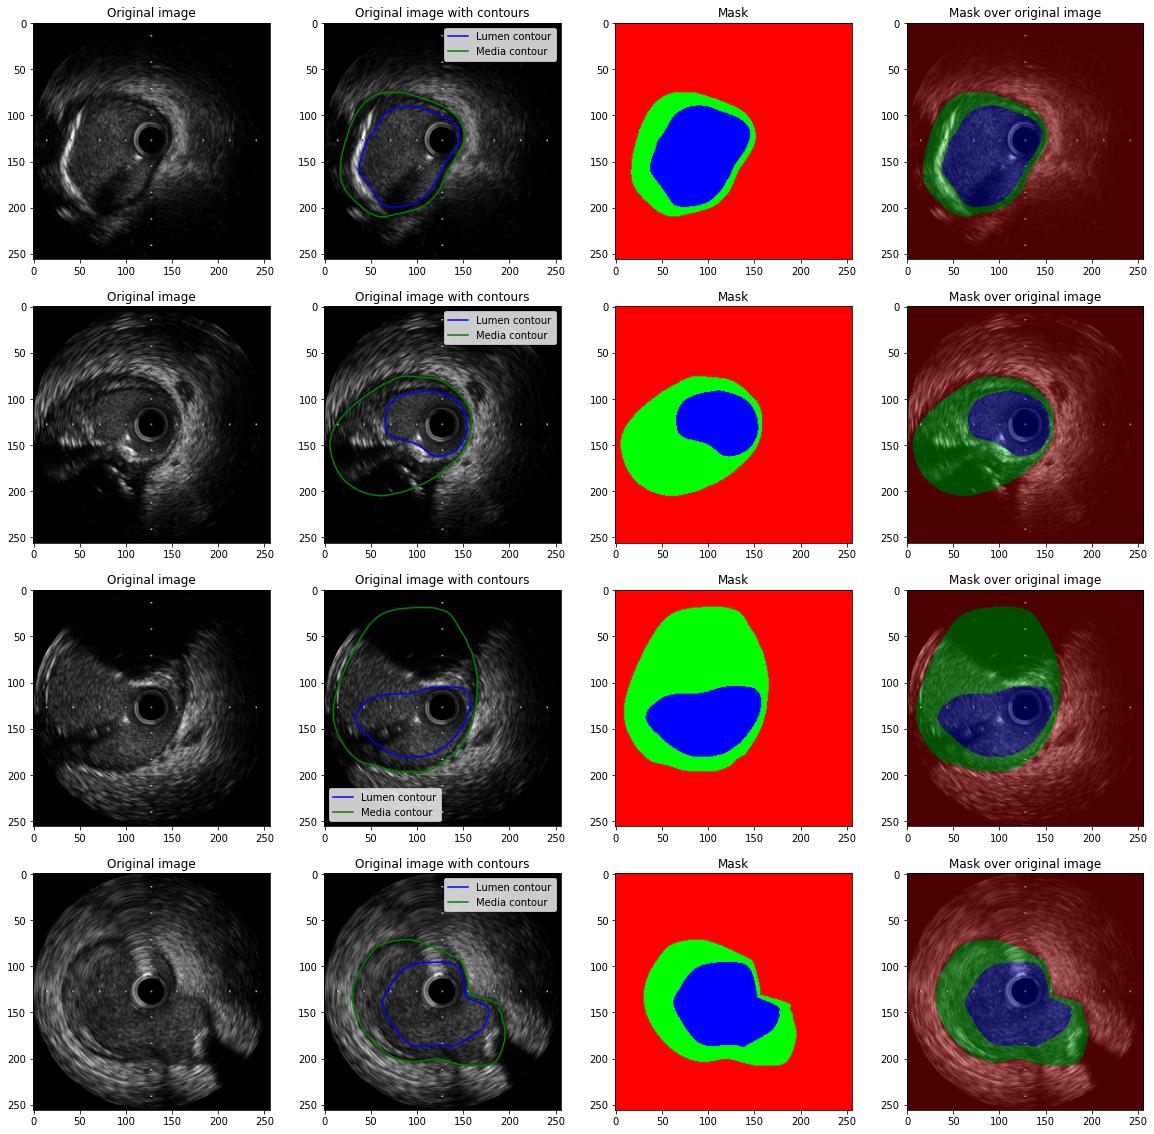

In [11]:
# Let's show some examples
plt.figure(figsize=(20, 20))

samples = 4

for i in range(samples):
    
    
    ax = plt.subplot(samples, 4, 4*i + 1)
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image')
    
    ax = plt.subplot(samples, 4, 4*i + 2)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-', label='Lumen contour')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-', label='Media contour')
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image with contours')
    plt.legend()
    
    
    mask = y_train_ds[i]/y_train_ds.max()
    ax = plt.subplot(samples, 4, 4*i + 3)
    plt.imshow(mask)
    plt.title('Mask')
    
    
    image = np.repeat(x_train_ds[i][2][..., np.newaxis], 3, axis=2)
    alpha = 0.7
    ax = plt.subplot(samples, 4, 4*i + 4)
    plt.imshow(np.uint8(image*alpha + mask*255*(1-alpha)))
    plt.title('Mask over original image')

### Data augmentation
We have 19 images to train using dataset A and 109 images in dataset B. Therefore we should apply Data Augmentation in order to get more training examples to feed into our model.

In this test we will only use the images adjacent to the middle image and we will pass these 3 images as 3 channels RGB to the data generator.

In [12]:
images = x_train_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (109, 384, 384, 3) (for dataset B)
masks = y_train_ds # Now the shape is (109, 384, 384, channels) (for dataset B)
num_classes = 3

print(f"Shape of set images: {images.shape}")
print(f"Shape of set masks: {masks.shape}")


batch_size = 8
input_shape = images.shape[1:] # (384, 384, 3)

images_test = x_test_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (num_images, 384, 384, 3) (for dataset B)
masks_test = np.copy(y_test_ds) # Now the shape is (num_images, 192, 192, channels) (for dataset B)

    
print(f"Shape of set images_test: {images_test.shape}")
print(f"Shape of set masks_test: {masks_test.shape}")

Shape of set images: (19, 256, 256, 3)
Shape of set masks: (19, 256, 256, 3)
Shape of set images_test: (174, 256, 256, 3)
Shape of set masks_test: (174, 256, 256, 3)


In [13]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20

def get_image_generator(data_gen_args=dict(data_format="channels_last", validation_split=0.15),
                        images=images,
                        masks=masks,
                        batch_size=batch_size):
    # we create two instances with the same arguments
    val_data_gen_args = dict(
        data_format=data_gen_args['data_format'],
        validation_split=data_gen_args['validation_split']
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    val_datagen = ImageDataGenerator(**val_data_gen_args)

    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    # Provide the same seed and keyword arguments to the fit and flow methods
    image_generator = image_datagen.flow(images, seed=seed, batch_size=batch_size, subset='training')
    mask_generator = mask_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='training')

    image_val_generator = val_datagen.flow(images, seed=seed, batch_size=batch_size, subset='validation')
    mask_val_generator = val_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='validation')

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    val_generator = zip(image_val_generator, mask_val_generator)
    
    return train_generator, val_generator

def gen_dtype(gen):
    while True:
        for i,j in gen:
            yield (i.astype('float32'), j.astype('float32'))

#def gen_dtype_test(gen):
#    for i,j in gen:
#        yield (i.astype('float32'), to_categorical(j.astype('int'), num_classes=num_classes))

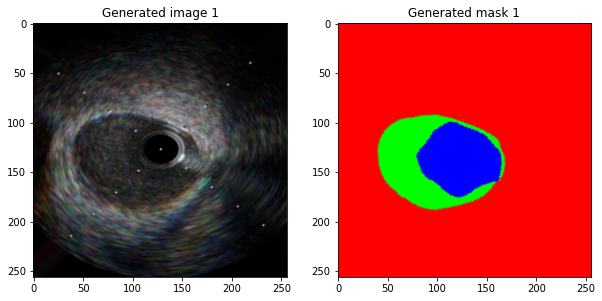

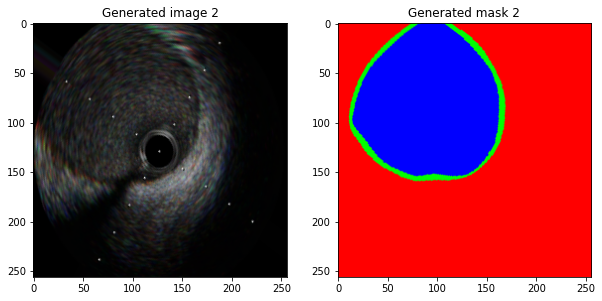

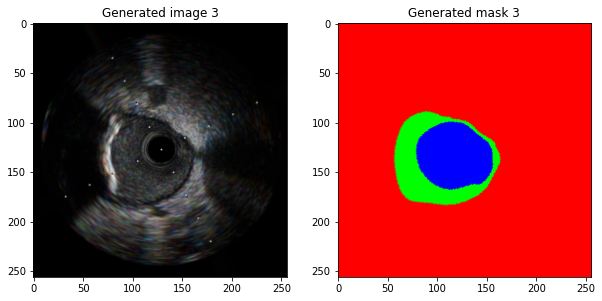

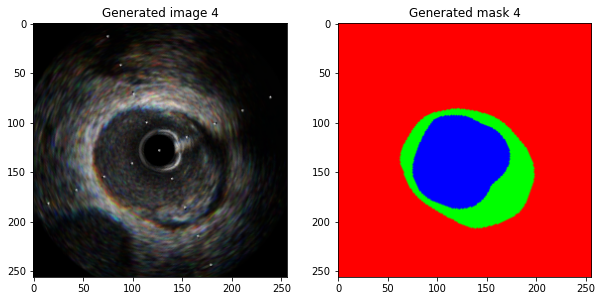

In [14]:
# Let's show some example
data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0.15
)
train_generator, val_generator = get_image_generator(data_gen_args)
images_gen, masks_gen = next(gen_dtype(train_generator))
samples = len(images_gen)

for i in range(4):
    plt.figure(figsize=(10,100))
    plt.subplot(samples, 2, 2*i+1)
    plt.imshow(images_gen[i], cmap='gray')
    plt.title(f"Generated image {i+1}")
    
    plt.subplot(samples, 2, 2*i+2)
    plt.imshow(masks_gen[i])
    plt.title(f"Generated mask {i+1}")

## Prepare and train the model
In this test we will use the <i>U-Net Xception-style</i> model from [this tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


def get_model(input_shape, num_classes, initializer):
    inputs = keras.Input(shape=input_shape)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same", kernel_initializer=initializer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer=initializer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer=initializer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same", kernel_initializer=initializer)(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same", kernel_initializer=initializer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same", kernel_initializer=initializer)(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same", kernel_initializer=initializer)(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax",
                            padding="same", kernel_initializer=initializer)(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(input_shape, num_classes, tf.keras.initializers.GlorotNormal(seed=seed))
model.summary()

2022-01-17 20:36:03.060356: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-17 20:36:03.087753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 20:36:03.087890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-17 20:36:03.087913: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-17 20:36:03.090560: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-17 20:36:03.090596: I tensorflow/st

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
from keras import backend as K

#calculates dice considering an input with a single class
def dice_single(true, pred, smooth=1.):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + smooth) / (true + pred + smooth)

def dice_for_class(index, smooth=1.):
    def dice_inner(true, pred):

        #get only the desired class
        true = true[:,:,:,index]
        pred = pred[:,:,:,index]

        #return dice per class
        return dice_single(true, pred, smooth)
    dice_inner.__name__ = f'dice_{CLASSES[index]}'
    return dice_inner


def dice_coef_loss(y_true, y_pred, smooth=1.):
    """
    Dice loss to minimize: 1 - Dice
    Dice = (2*|X & Y|)/ (|X| + |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    # Ignore label 0 which belongs to background
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred, axis=-1)
    denom = K.sum(y_true + y_pred, axis=-1)
    dice = K.mean(((2. * intersection + smooth) / (denom + smooth)))
    return 1 - dice

    
def jaccard_coef_loss(y_true, y_pred, smooth=1.):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    
    source code: 
    https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
    
    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The target distribution, format the same with `output`.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background),
            dice = ```smooth/(small_value + smooth)``,
            then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
            so in this case, higher smooth can have a higher dice.
            
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [17]:
# Classification metrics
def get_specificity(col, cm):
    """Return the specificity of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tn)/float(tn+fp)

def get_accuracy(col, cm):
    """Return the accuracy of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tp+tn)/float(tp+tn+fp+fn)

from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from skimage.metrics import hausdorff_distance
import pandas as pd

def custom_classification_report(y_true, y_pred, classes=['background', 'media', 'lumen']):
    
    # Obtain precision, recall, f1-score and support
    data = classification_report(
        y_true.flatten(),
        y_pred.flatten(),
        output_dict=True,
        target_names=classes
    )
    data.pop('macro avg')
    data.pop('weighted avg')
    data.pop('accuracy')
    
    # Get jaccard score
    jacc = jaccard_score(
        y_true.flatten(),
        y_pred.flatten(),
        average=None
    )
    
    # Compute hausdorff distance of every image
    hausdorff_dist_list = np.zeros((len(classes), len(y_true)))
    for i in range(len(y_true)):
        # Ground truth
        gt = y_true[i]
        # Predicted segmentation
        seg = y_pred[i]

        # Evaluate for each class
        for j in range(len(classes)):
            hausdorff_dist_list[j, i] = hausdorff_distance(gt==j, seg==j)
    hd = hausdorff_dist_list
    
    # Finally compute specificity
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    for i in range(len(classes)):
        data[classes[i]]['specificity'] = get_specificity(i, cm)
        data[classes[i]]['accuracy'] = get_accuracy(i, cm)
        data[classes[i]]['jaccard_score'] = jacc[i]
        data[classes[i]]['hausdorff_dist'] = hd[i]
    
    return pd.DataFrame(data)

In [18]:
from sklearn.model_selection import KFold

def get_callbacks(name_weights, patience_lr):
    mcp_save = keras.callbacks.ModelCheckpoint(
        name_weights,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.1,
        patience=patience_lr,
        verbose=1,
        min_delta=1e-4,
        mode='min'
    )
    return [mcp_save, reduce_lr_loss]

loss = jaccard_coef_loss
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
metrics = [dice_for_class(i) for i in range(num_classes)]

data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0
)

In [19]:
foldsA = [(0,
  (np.array([ 0,  1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17]),
   np.array([ 4,  5, 16, 18]))),
 (1,
  (np.array([ 1,  2,  3,  4,  5,  6,  9, 10, 11, 13, 14, 15, 16, 17, 18]),
   np.array([ 0,  7,  8, 12]))),
 (2,
  (np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 16, 17, 18]),
   np.array([ 9, 11, 14, 15]))),
 (3,
  (np.array([ 0,  2,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18]),
   np.array([ 1,  3,  6, 10]))),
 (4,
  (np.array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 18]),
   np.array([ 2, 13, 17])))]


Fold  0

Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


2022-01-17 20:41:16.881957: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_2 is not found
Traceback (most recent call last):

  File "/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_2 is not found


2022-01-17 20:41:16.882068: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_2 is not found
Traceback (most recent call last):

  File "/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_2 is not found


	 [[{{node PyFunc}}]]



Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00131: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00161: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00176: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00206: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
6/6 [==============================] - 3s 350ms/step - loss: 0.0859 - dice_background: 0.9405 - dice_media: 1.6155e-04 - dice_lumen: 0.8125


background  \
precision                                                0.895876   
recall                                                    0.99151   
f1-score                                                  0.94127   
support                                                   8774622   
specificity                                              0.550154   
accuracy                                                 0.901503   
jaccard_score                                            0.889056   
hausdorff_dist  [38.47076812334269, 33.0, 39.0, 54.37830449729...   

                                                            media  \
precision                                                     0.0   
recall                                                        0.0   
f1-score                                                      0.0   
support                                                   1267864   
specificity                                                   1.0   
accuracy                                                 0.886845   
jaccard_score                                                 0.0   
hausdorff_dist  [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...   

                                                            lumen  
precision                                                0.730902  
recall                                                   0.908787  
f1-score                                                 0.810195  
support                                                   1360778  
specificity                                              0.950269  
accuracy                                                 0.944902  
jaccard_score                                            0.680948  
hausdorff_dist  [15.524174696260024, 32.202484376209235, 13.60...


Fold  1

Epoch 00173: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00235: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00250: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
6/6 [==============================] - 1s 210ms/step - loss: 0.0665 - dice_background: 0.9577 - dice_media: 0.5464 - dice_lumen: 0.8317


background  \
precision                                                0.937622   
recall                                                   0.980437   
f1-score                                                 0.958552   
support                                                   8774622   
specificity                                              0.744645   
accuracy                                                 0.932462   
jaccard_score                                            0.920402   
hausdorff_dist  [20.12461179749811, 18.384776310850235, 20.0, ...   

                                                            media  \
precision                                                0.576741   
recall                                                   0.547107   
f1-score                                                 0.561533   
support                                                   1267864   
specificity                                              0.949535   
accuracy                                                 0.904602   
jaccard_score                                            0.390369   
hausdorff_dist  [20.12461179749811, 18.027756377319946, 19.723...   

                                                            lumen  
precision                                                0.951344  
recall                                                   0.716762  
f1-score                                                 0.817559  
support                                                   1360778  
specificity                                              0.994663  
accuracy                                                 0.959345  
jaccard_score                                            0.691416  
hausdorff_dist  [11.704699910719626, 10.770329614269007, 20.12...


Fold  2

Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00157: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00232: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00247: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
6/6 [==============================] - 1s 220ms/step - loss: 0.0615 - dice_background: 0.9612 - dice_media: 0.5672 - dice_lumen: 0.8509


background  \
precision                                                0.944879   
recall                                                   0.979349   
f1-score                                                 0.961806   
support                                                   8774622   
specificity                                              0.778658   
accuracy                                                 0.938176   
jaccard_score                                            0.926421   
hausdorff_dist  [25.298221281347036, 16.1245154965971, 18.3575...   

                                                            media  \
precision                                                0.612546   
recall                                                   0.552225   
f1-score                                                 0.580824   
support                                                   1267864   
specificity                                              0.956151   
accuracy                                                   0.9111   
jaccard_score                                            0.409268   
hausdorff_dist  [25.079872407968907, 25.0, 23.259406699226016,...   

                                                            lumen  
precision                                                0.912381  
recall                                                   0.781468  
f1-score                                                 0.841866  
support                                                   1360778  
specificity                                              0.989131  
accuracy                                                  0.96286  
jaccard_score                                            0.726916  
hausdorff_dist  [9.848857801796104, 25.0, 23.08679276123039, 3...


Fold  3

Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00133: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00148: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00173: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00188: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00203: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00233: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00248: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
6/6 [=======

background  \
precision                                                0.903942   
recall                                                   0.990648   
f1-score                                                 0.945311   
support                                                   8774622   
specificity                                              0.579333   
accuracy                                                 0.908319   
jaccard_score                                            0.896294   
hausdorff_dist  [42.42640687119285, 29.0, 34.0, 51.0, 42.48529...   

                                                            media  \
precision                                                     0.0   
recall                                                        0.0   
f1-score                                                      0.0   
support                                                   1267864   
specificity                                                   1.0   
accuracy                                                 0.887126   
jaccard_score                                                 0.0   
hausdorff_dist  [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...   

                                                            lumen  
precision                                                0.711891  
recall                                                   0.934855  
f1-score                                                 0.808278  
support                                                   1360778  
specificity                                              0.944084  
accuracy                                                 0.942895  
jaccard_score                                            0.678244  
hausdorff_dist  [15.132745950421556, 37.64306044943742, 12.529...


Fold  4

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00144: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00159: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 00174: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.

Epoch 00189: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.

Epoch 00219: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.

Epoch 00234: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.

Epoch 00249: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
6/6 [=======

background  \
precision                                                0.894748   
recall                                                   0.995175   
f1-score                                                 0.942293   
support                                                   8774622   
specificity                                              0.542671   
accuracy                                                 0.902952   
jaccard_score                                            0.890883   
hausdorff_dist  [40.607881008493905, 37.0, 37.33630940518894, ...   

                                                            media  \
precision                                                     0.0   
recall                                                        0.0   
f1-score                                                      0.0   
support                                                   1267864   
specificity                                                   1.0   
accuracy                                                  0.88699   
jaccard_score                                                 0.0   
hausdorff_dist  [inf, inf, inf, inf, inf, inf, inf, inf, inf, ...   

                                                            lumen  
precision                                                 0.74152  
recall                                                   0.895732  
f1-score                                                 0.811363  
support                                                   1360778  
specificity                                              0.953601  
accuracy                                                 0.946114  
jaccard_score                                              0.6826  
hausdorff_dist  [14.866068747318506, 31.38470965295043, 12.083...

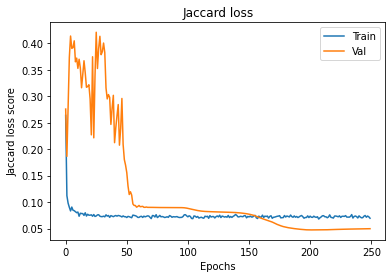

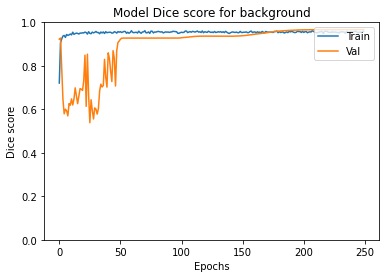

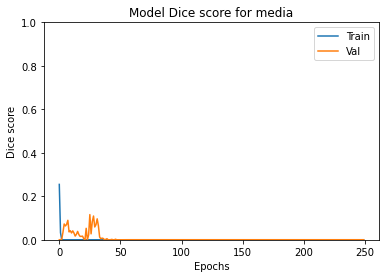

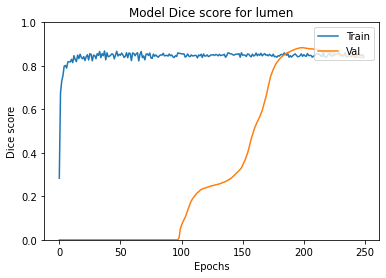

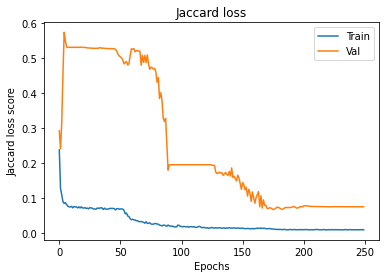

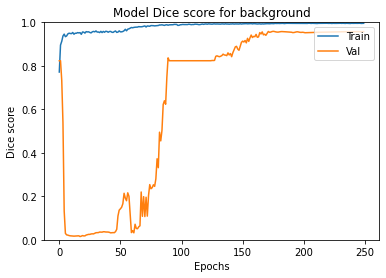

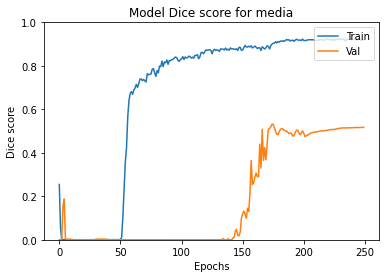

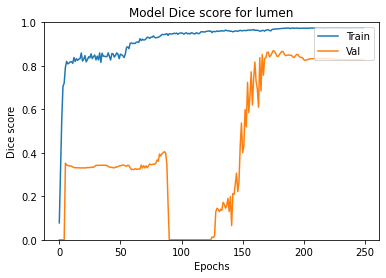

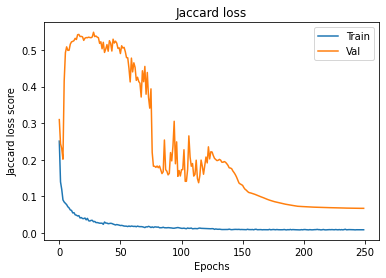

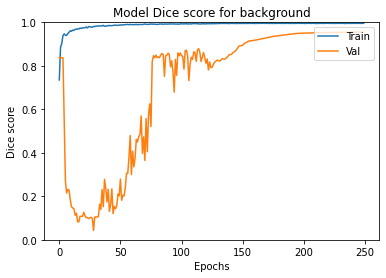

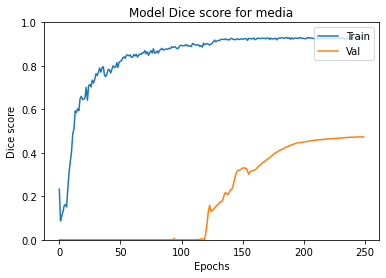

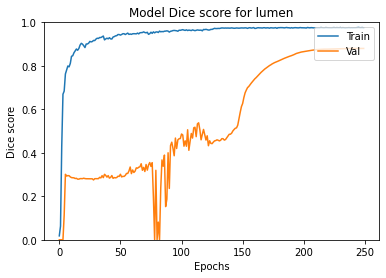

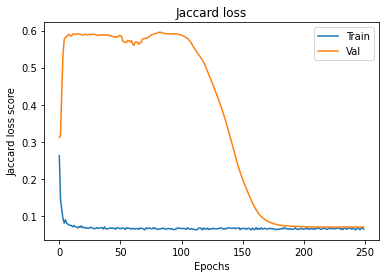

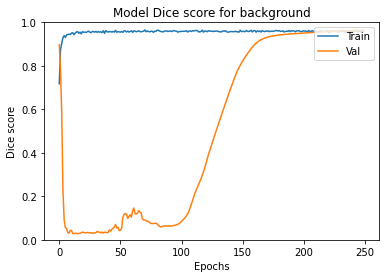

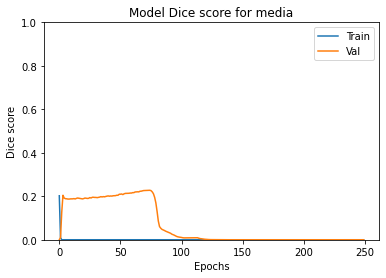

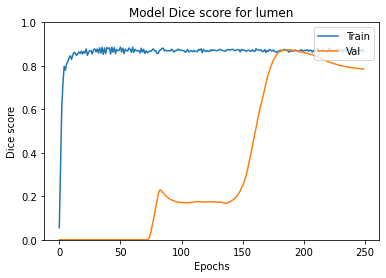

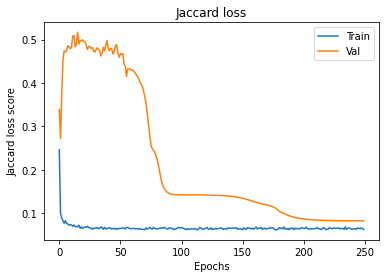

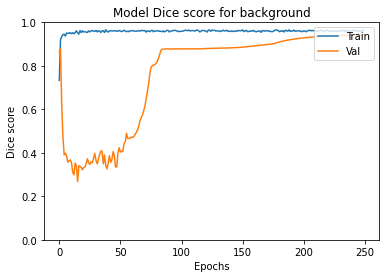

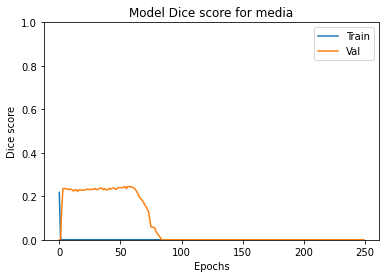

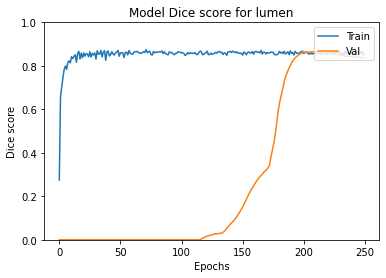

In [22]:
from tensorflow.keras import backend as K

# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

data_by_fold = []

for j, (train_idx, val_idx) in foldsA:
    
    # Free up RAM in case the model definition cells were run multiple times
    K.clear_session()
    epochs = 250
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-05, decay=0.0)
    
    print('\nFold ',j)
    X_train_cv = images[train_idx]
    y_train_cv = masks[train_idx]
    X_valid_cv = images[val_idx]
    y_valid_cv = masks[val_idx]
    
    name_weights = f"modelB_fold{j}-datasetA"
    callbacks = get_callbacks(name_weights=name_weights, patience_lr=15)
    train_generator, val_generator = get_image_generator(data_gen_args, images=X_train_cv, masks=y_train_cv)
    
    model = get_model(input_shape, num_classes, tf.keras.initializers.GlorotNormal(seed=seed))
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    history = model.fit(
        gen_dtype(train_generator),
        validation_data=(X_valid_cv, y_valid_cv),
        shuffle=True,
        steps_per_epoch=5*len(X_train_cv)/batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )
    
    f1 = plt.figure(4*j+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Jaccard loss')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard loss score')
    plt.legend(['Train', 'Val'], loc='upper right')
    f1.show()

    f2 = plt.figure(4*j+2)
    plt.plot(history.history['dice_background'])
    plt.plot(history.history['val_dice_background'])
    plt.title('Model Dice score for background')
    plt.xlabel('Epochs')
    plt.ylabel('Dice score')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f2.show()

    f3 = plt.figure(4*j+3)
    plt.plot(history.history['dice_media'])
    plt.plot(history.history['val_dice_media'])
    plt.title('Model Dice score for media')
    plt.xlabel('Epochs')
    plt.ylabel('Dice score')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f3.show()

    f4 = plt.figure(4*j+4)
    plt.plot(history.history['dice_lumen'])
    plt.plot(history.history['val_dice_lumen'])
    plt.title('Model Dice score for lumen')
    plt.xlabel('Epochs')
    plt.ylabel('Dice score')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f4.show()
    
    score = model.evaluate(images_test, masks_test, verbose=1)
    
    masks_test_from_pred = get_class_mask_from_prediction(masks_test)
    prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(images_test)])
    
    df = custom_classification_report(masks_test_from_pred, prediction_masks_test)
    
    display(df)
    
    data_by_fold.append(df)

In [23]:
import math
data = data_by_fold[0].copy(deep=True)
for cls in ['background', 'media', 'lumen']:
    for metric in ['precision', 'recall', 'f1-score', 'accuracy', 'specificity', 'jaccard_score']:
        l = [fold[cls][metric] for fold in data_by_fold]
        data[cls][metric] = f"{np.mean(l)}({np.std(l)})"
    
    hausdorff_list = []
    for fold in data_by_fold:
        if math.inf not in list(fold[cls]['hausdorff_dist']):
            hausdorff_list += list(fold[cls]['hausdorff_dist'])
    
    data[cls]['hausdorff_dist'] = f"{np.mean(hausdorff_list)}({np.std(hausdorff_list)})"
    
display(data)
data.to_csv(os.path.join(os.getcwd(), "output", "B", "metrics-modelB-datasetA.csv"))

background  \
precision       0.9154133345881481(0.021456036262649733)   
recall          0.9874239596873803(0.006343226040487599)   
f1-score        0.9498462814986217(0.008602051848310872)   
support                                          8774622   
specificity      0.6390921933740047(0.10138854880105613)   
accuracy        0.9166823246371335(0.015490912974643563)   
jaccard_score    0.9046112856413637(0.01565028505931937)   
hausdorff_dist    29.299175045292817(11.453742913247272)   

                                                   media  \
precision         0.237857507825444(0.29153471853467505)   
recall           0.21986632635677011(0.2692850193549584)   
f1-score        0.22847138026118188(0.27988563587306897)   
support                                          1267864   
specificity     0.9811371396059737(0.023196731060466044)   
accuracy        0.8953324463915402(0.010426001655869634)   
jaccard_score    0.15992748485310151(0.1959615192801791)   
hausdorff_dist     31.35152443072003(13.671169715397683)   

                                                   lumen  
precision         0.809607485268925(0.10102553976234963)  
recall           0.8475207565084093(0.08386397384448124)  
f1-score        0.8178522547092217(0.012402731580714487)  
support                                          1360778  
specificity     0.9663496123905011(0.021154165775971352)  
accuracy        0.9512231831715899(0.008207197114568954)  
jaccard_score   0.6920247042333503(0.017995429469850496)  
hausdorff_dist    24.549329480451252(14.845854221885935)

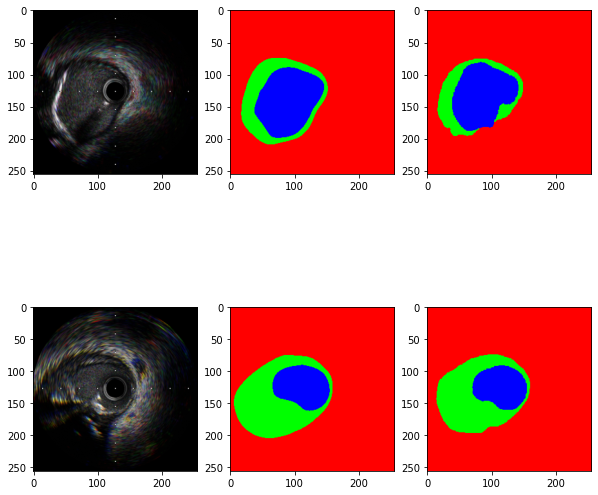

In [25]:
# Show some predictions from the training dataset
plt.figure(figsize=(10,10))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

best_model = get_model(input_shape, num_classes, tf.keras.initializers.GlorotNormal(seed=seed))

best_model.load_weights("modelB_fold1-datasetA")

best_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

samples = 2

test_images = images[:samples]
test_masks = masks[:samples]
test_predictions = best_model.predict(test_images)

for i in range(samples):
    
    plt.subplot(samples, 3, 3*i + 1)
    plt.imshow(test_images[i])
    
    plt.subplot(samples, 3, 3*i + 2)
    plt.imshow(test_masks[i])
    
    plt.subplot(samples, 3, 3*i + 3)
    plt.imshow(get_mask_from_prediction(test_predictions[i]))

In [26]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

def print_predictions(image, ground_truth, prediction, save_filename=None):
    image = np.copy(image)
    ground_truth = np.copy(ground_truth)
    prediction = np.copy(prediction)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 5, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    plt.subplot(1, 5, 2)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(ground_truth)
    
    plt.subplot(1, 5, 3)
    plt.title("Prediction")
    plt.axis('off')
    plt.imshow(prediction) 

    handles = [
        mpatches.Patch(color='red', label='Ground Truth & Not Predicted'),
        mpatches.Patch(color='xkcd:green', label='Not Ground Truth & Predicted'),
        mpatches.Patch(color='blue', label='Ground Truth & Predicted')
    ]
    
    media_image = np.zeros(image.shape)
    media_image[:, :, 0][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==0)] = 1
    media_image[:, :, 1][(ground_truth[:, :, 1]==0) & (prediction[:, :, 1]==1)] = 1
    media_image[:, :, 2][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==1)] = 1
    plt.subplot(1, 5, 4)
    plt.title("Media prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(media_image)
    
    lumen_image = np.zeros(image.shape)
    lumen_image[:, :, 0][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==0)] = 1
    lumen_image[:, :, 1][(ground_truth[:, :, 2]==0) & (prediction[:, :, 2]==1)] = 1
    lumen_image[:, :, 2][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==1)] = 1
    plt.subplot(1, 5, 5)
    plt.title("Lumen prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(lumen_image)
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", "B", "predictions", save_filename))

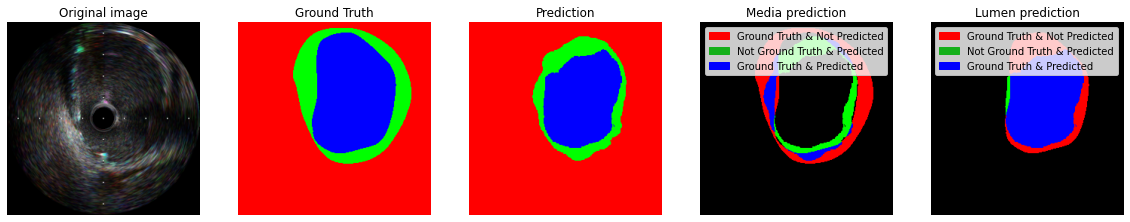

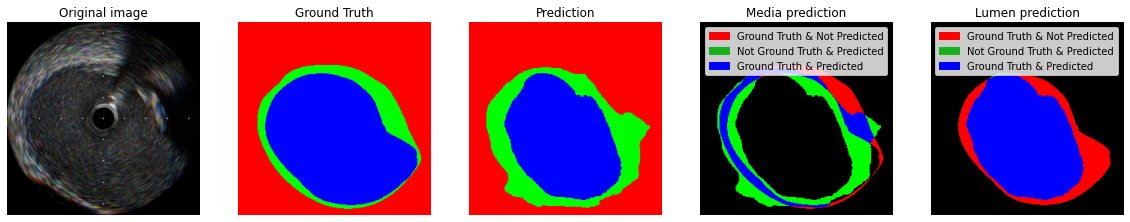

In [27]:
# Show some predictions from the training dataset
import random


samples = 2


random_num = random.randint(0, len(images)-samples)

test_images = images[random_num:random_num+samples]
test_masks = masks[random_num:random_num+samples]
test_predictions = best_model.predict(test_images)

for i in range(samples):
    print_predictions(test_images[i], test_masks[i], get_mask_from_prediction(test_predictions[i]))

## Let's test our model

In [28]:
score = best_model.evaluate(images_test, masks_test, verbose=1)
print("Test loss:", score[0])
print("Test metric:", score[1])
print("Test metric:", score[2])
print("Test metric:", score[3])

6/6 [==============================] - 2s 208ms/step - loss: 0.0644 - dice_background: 0.9577 - dice_media: 0.5275 - dice_lumen: 0.8494
Test loss: 0.0643673986196518
Test metric: 0.9576683640480042
Test metric: 0.5274940729141235
Test metric: 0.8494391441345215


2022-01-17 22:11:50.370548: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: callback pyfunc_5 is not found
Traceback (most recent call last):

  File "/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_5 is not found


2022-01-17 22:11:50.370646: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_5 is not found
Traceback (most recent call last):

  File "/home/annon20/Documents/UB/TFG/tfg-venv/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_5 is not found


	 [[{{node PyFunc}}]]


<Figure size 720x2880 with 0 Axes>

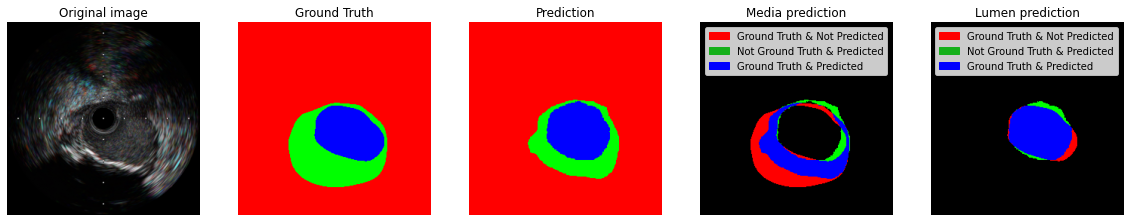

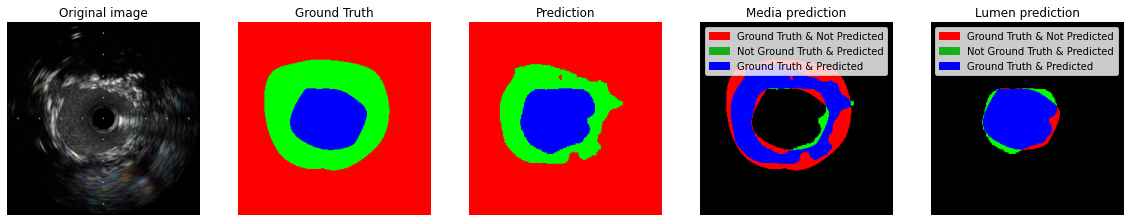

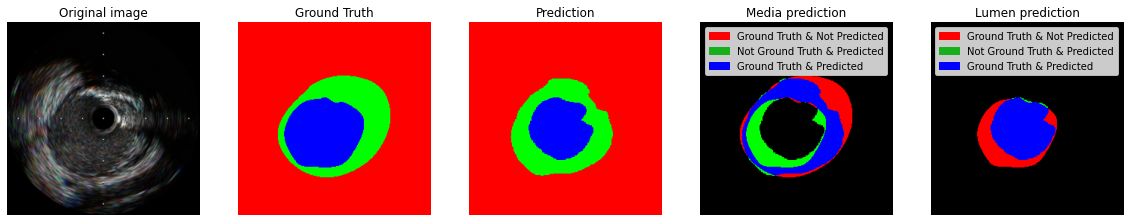

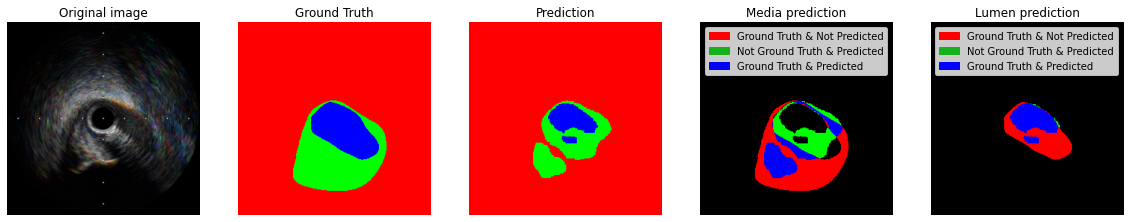

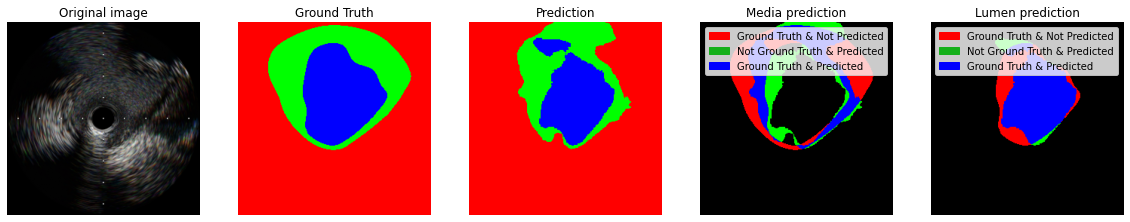

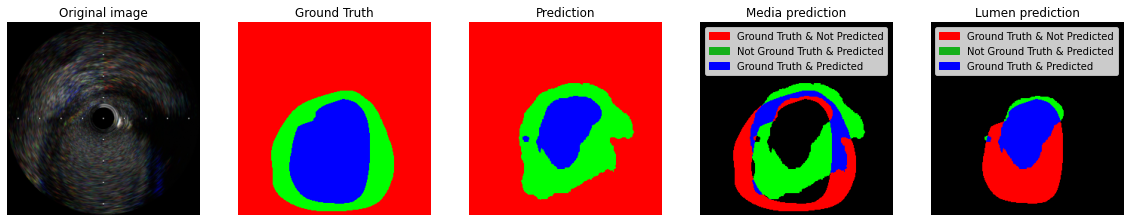

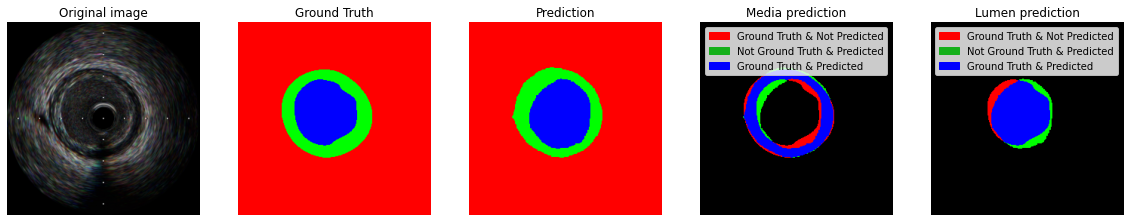

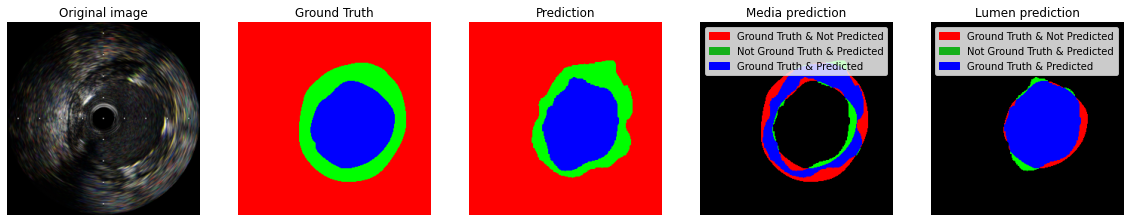

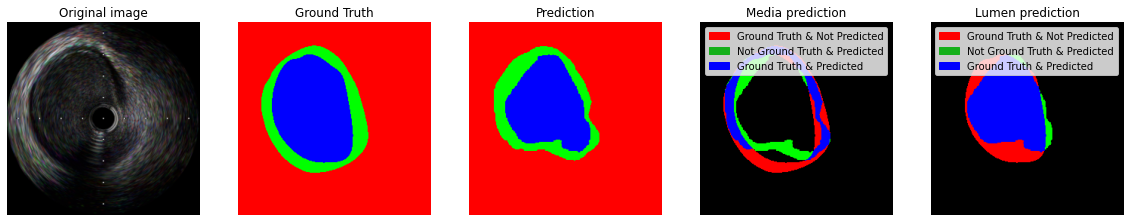

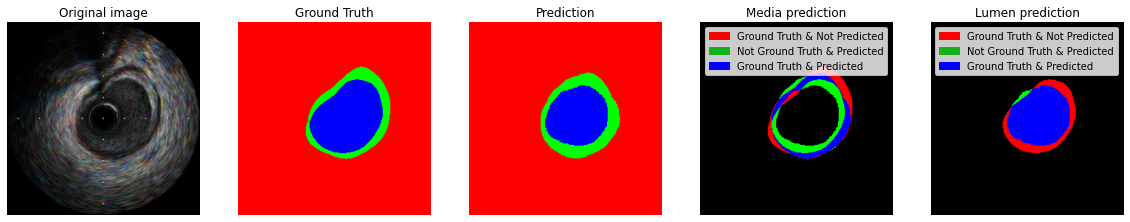

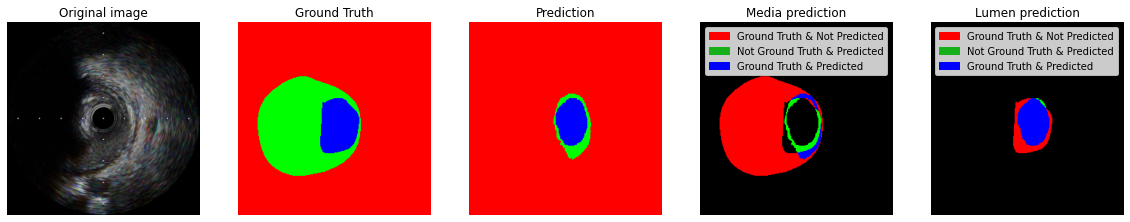

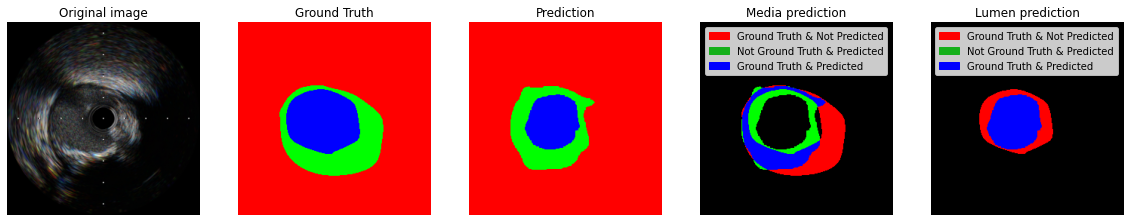

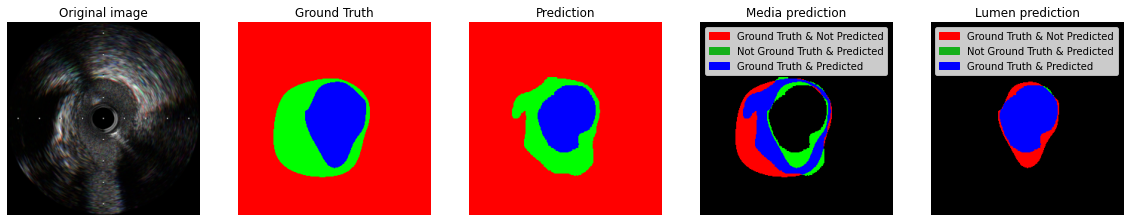

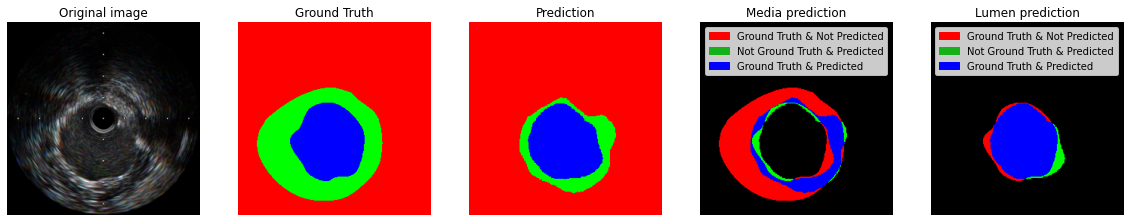

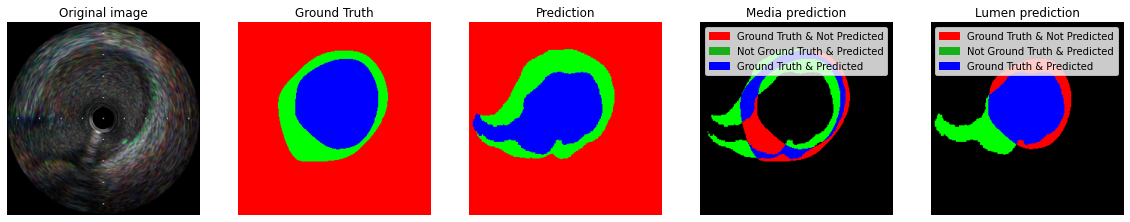

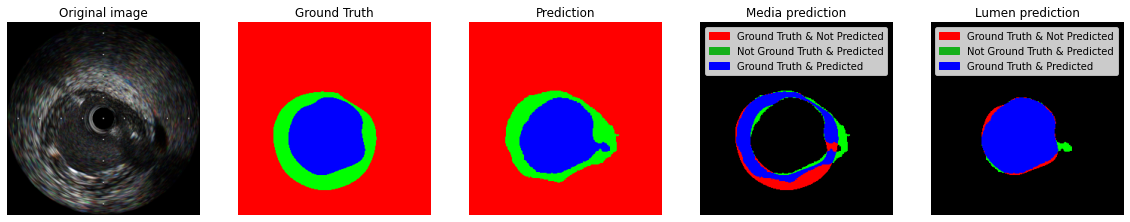

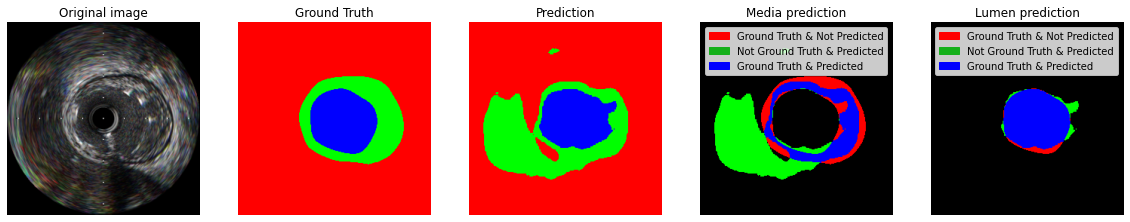

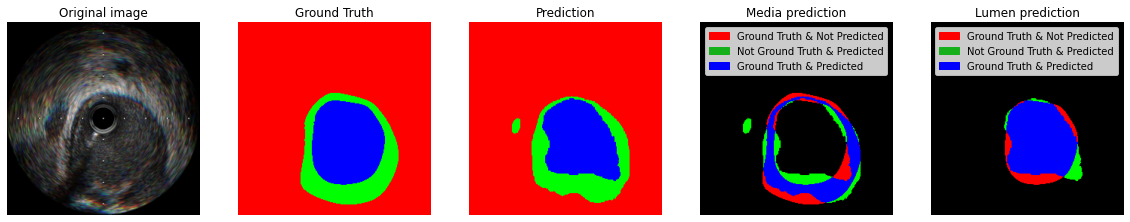

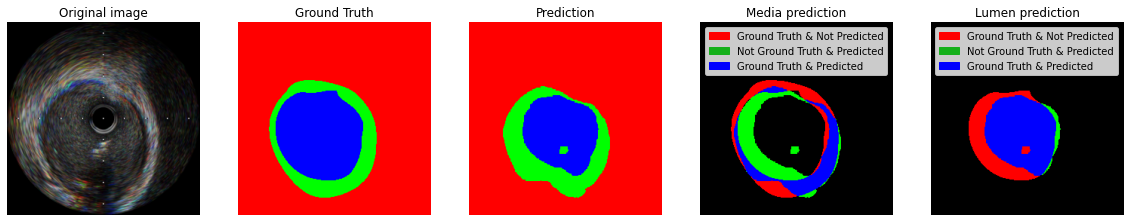

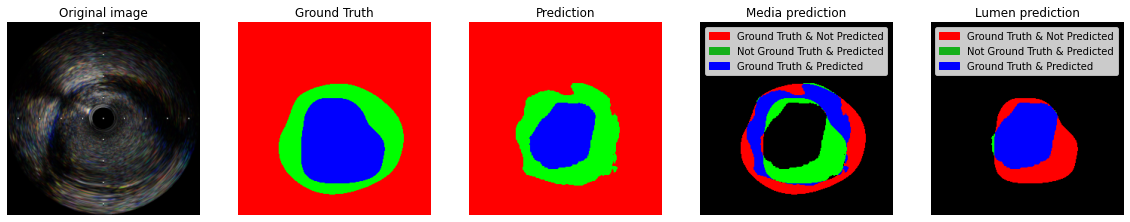

In [29]:
# Show some predictions from the test dataset
plt.figure(figsize=(10,40))

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

samples = 20

test_images = images_test[:samples]
test_masks = masks_test[:samples]
test_predictions = best_model.predict(test_images)

for i in range(samples):
    save_filename=f"frame_{20+i:02}_00{20+i:02}_003.png"
    print_predictions(
        test_images[i],
        test_masks[i],
        get_mask_from_prediction(test_predictions[i]),
        save_filename=save_filename
    )

## Now let's plot some measures of our results
First, we will plot the confusion matrix to see which classes are overpredicted and which ones are underpredicted. We expect that the model overpredicts the background.

In [30]:
# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)
    
masks_test = get_class_mask_from_prediction(masks_test)
prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in best_model.predict(images_test)])

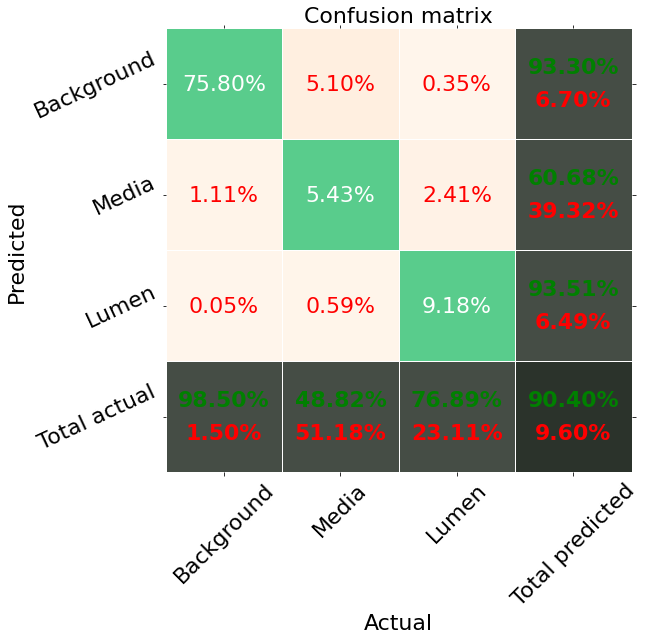

In [32]:
from confusion_matrix_pretty_print import pp_matrix_from_data
pp_matrix_from_data(
    masks_test.flatten(),
    prediction_masks_test.flatten(),
    columns=['Background', 'Media', 'Lumen'],
    fz=22
)